In [1]:
from functools import partial
import pathlib

import astropy.table as at
from astropy.convolution import convolve, Gaussian2DKernel
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import gala.integrate as gi
from gala.units import galactic
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic_2d
from scipy.interpolate import interp1d
import cmasher as cmr

import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti

$$
\Phi(z) = \frac{1}{2} \, \Omega^2  \, z^2\\
E_z = \frac{1}{2} \, v_z^2 + \Phi(z)\\
J_z = E_z / \Omega
$$

First, figure out $E_z$ and $J_z$ for $z_{\rm max} = 1$:

In [2]:
Omega = 0.08 * u.rad / u.Myr

scale_vz = 50 * u.km / u.s
sz = (scale_vz / np.sqrt(Omega)).decompose(galactic)  # .value

In [3]:
N = 2**18

rng = np.random.default_rng(42)
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    Jzs = (rng.exponential(scale=sz.value**2, size=N) * sz.unit**2).to(
        galactic["length"] ** 2 / galactic["time"]
    )
    thzs = rng.uniform(0, 2 * np.pi, size=N)

In [4]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    pdata = {
        "z": (np.sqrt(2 * Jzs / Omega) * np.sin(thzs)).to(galactic["length"]),
        "vz": (np.sqrt(2 * Jzs * Omega) * np.cos(thzs)).to(
            galactic["length"] / galactic["time"]
        ),
    }
    pdata["rz"] = np.sqrt(pdata["z"] ** 2 * Omega + pdata["vz"] ** 2 / Omega)

In [5]:
pdata

{'z': <Quantity [ 0.78140167, -1.36064321, -0.26929203, ..., -0.3796875 ,
             0.03831542, -0.35293775] kpc>,
 'vz': <Quantity [ 0.0930888 , -0.01920764, -0.1095786 , ...,  0.00920747,
            -0.0494805 ,  0.03713139] kpc / Myr>,
 'rz': <Quantity [0.39644186, 0.39079363, 0.3948352 , ..., 0.11221732, 0.17527535,
            0.16492257] kpc rad(1/2) / Myr(1/2)>}

In [259]:
max_rzp = (5 * scale_vz / np.sqrt(Omega)).decompose(galactic)
max_rzp.value

0.9039583838822332

In [260]:
with u.set_enabled_equivalencies(u.dimensionless_angles()):
    max_z = (max_rzp / np.sqrt(Omega)).to(galactic["length"])
    max_vz = (max_rzp * np.sqrt(Omega)).to(galactic["velocity"])

max_z = np.round(max_z, 0)
max_vz = np.round(max_vz, 0)
max_z, max_vz

(<Quantity 3. kpc>, <Quantity 250. km / s>)

In [261]:
zbins = np.linspace(-max_z.value, max_z.value, 151)
zvz_bins = {"z": zbins, "vz": Omega * zbins}
data = oti.DensityOrbitModel.get_data_im(
    z=pdata["z"],
    vz=pdata["vz"],
    bins=zvz_bins,
)

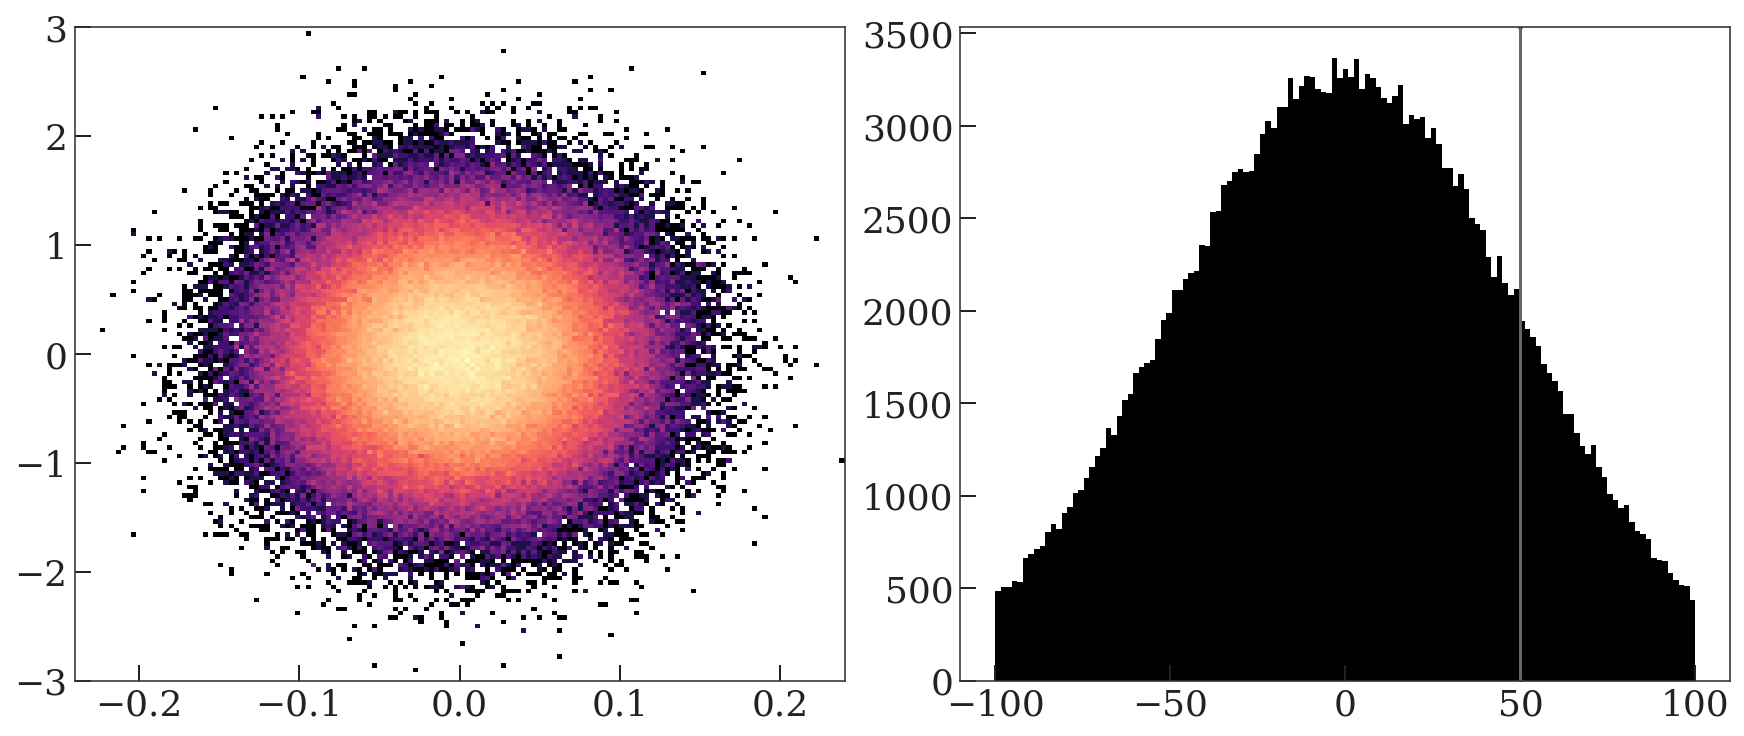

In [262]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
axes[0].pcolormesh(data["vz"], data["z"], data["H"], norm=mpl.colors.LogNorm())
axes[1].hist(pdata["vz"].to_value(u.km / u.s), bins=np.linspace(-100, 100, 128))
axes[1].axvline(scale_vz.value)

In [264]:
n_dens_knots = 10

# Knot locations, spaced equally in r_z
ln_dens_knots = jnp.linspace(0, max_rzp.value, n_dens_knots)


def ln_dens_func(rz, ln_dens_vals):
    return oti.model_helpers.monotonic_quadratic_spline(
        ln_dens_knots**2, ln_dens_vals, rz**2
    )


ln_dens_bounds = {
    "ln_dens_vals": (
        np.concatenate(([-5], jnp.full(n_dens_knots - 1, -25.0))),
        np.concatenate(([25], jnp.full(n_dens_knots - 1, 0.0))),
    )
}

In [265]:
# NOTE: ln_Omega is degenerate with e2 value at small rz, so we only use a few knots

n_knots = {2: 5}  # , 4: 9}
e_knots = {m: jnp.linspace(0, ln_dens_knots.max(), n_knots[m]) for m in n_knots}
e_signs = {2: 1.0, 4: -1.0}


def e_func_base(rzp, vals, m):
    return e_signs[m] * oti.model_helpers.monotonic_quadratic_spline(
        e_knots[m], jnp.concatenate((jnp.array([0.0]), vals)), rzp
    )


e_funcs = {m: partial(e_func_base, m=m) for m in e_knots}

e_params0 = {m: {"vals": np.zeros(n_knots[m] - 1)} for m in e_funcs}
e_bounds = {
    m: {"vals": (np.full(n_knots[m] - 1, 0), np.full(n_knots[m] - 1, 1))}
    for m in e_funcs
}

In [266]:
# n_e2_knots = 11

# e2_knots = jnp.linspace(0, ln_dens_knots.max(), n_e2_knots)


# def e2_func(rzp, e2_vals):
#     return oti.model_helpers.monotonic_quadratic_spline(
#         e2_knots, jnp.concatenate((jnp.array([0.0]), e2_vals)), rzp
#     )


# e_params0 = {2: {"e2_vals": np.zeros(n_e2_knots - 1)}}
# e_bounds = {2: {"e2_vals": (np.full(n_e2_knots - 1, 0), np.full(n_e2_knots - 1, 1))}}

In [352]:
def reg_func(params):
    p = 0.0

    #     p += jnp.sum((params['e_params'][2]['vals'])**2 / 0.1**2)
    for k in params["e_params"]:
        p += jnp.sum(jnp.abs(params["e_params"][k]["vals"]) / 0.1)

    #     p += jnp.sum(jnp.abs(params['ln_dens_params']['ln_dens_vals']) / 1.)

    return p

In [353]:
model = oti.DensityOrbitModel(
    ln_dens_func=ln_dens_func,
    e_funcs=e_funcs,
    regularization_func=reg_func,
    unit_sys=galactic,
)

In [354]:
params0 = model.get_params_init(
    pdata["z"], pdata["vz"], ln_dens_params0={"ln_dens_vals": np.zeros(n_dens_knots)}
)

# OVERWRITE
# params0['ln_dens_params'] = {'ln_dens_vals': np.zeros(n_dens_knots)}
params0["e_params"] = e_params0
params0

/mnt/ceph/users/apricewhelan/projects/torusimaging/torusimaging/model.py:96: RuntimeWarning: With custom e_funcs, you must set your own initial parameters. Use the dictionary returned by this function and add initial guesses for all parameters expected by the e_funcs.
  warn(


{'z0': 0.0022067129262578495,
 'vz0': -9.850438399861564e-05,
 'ln_Omega': -2.5232632535802897,
 'ln_dens_params': {'ln_dens_vals': Array([ 5.46886842e+00, -1.59062902e+01, -1.52134681e+01, -1.50917119e+01,
         -1.60197484e+01, -1.26818858e+01, -2.33947835e+01,  1.80297887e-13,
         -5.12586619e-13,  2.27509005e-13], dtype=float64)},
 'e_params': {2: {'vals': array([0., 0., 0., 0.])}}}

In [355]:
bounds = {}

_dens0 = [0.01, 2] * u.Msun / u.pc**3
bounds["ln_Omega"] = (np.log(1e-4), np.log(1e0))
bounds["z0"] = (-0.5, 0.5)
bounds["vz0"] = (-0.05, 0.05)

bounds["e_params"] = e_bounds
bounds["ln_dens_params"] = ln_dens_bounds

Text(0.5, 1.0, 'initial model')

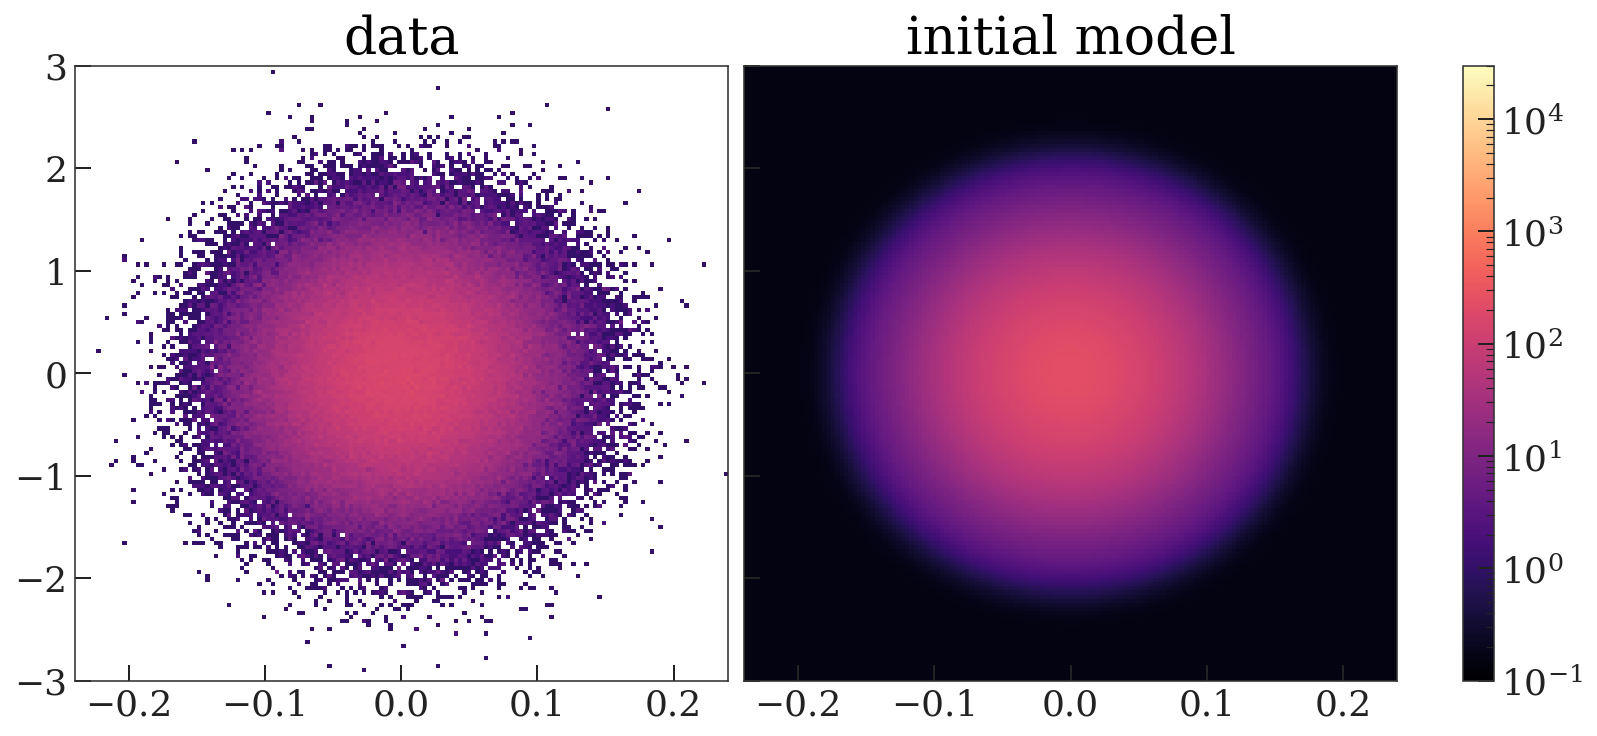

In [356]:
vlim = dict(
    norm=mpl.colors.LogNorm(vmax=3e4, vmin=1e-1), shading="auto"
)  # vmin=0, vmax=30)

fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), sharex=True, sharey=True, constrained_layout=True
)

cs = axes[0].pcolormesh(data["vz"], data["z"], data["H"], **vlim)

cs = axes[1].pcolormesh(
    data["vz"],
    data["z"],
    np.exp(model.ln_density(z=data["z"], vz=data["vz"], params=params0)),
    **vlim
)
fig.colorbar(cs, ax=axes[:2])

axes[0].set_title("data")
axes[1].set_title("initial model")

In [357]:
model.objective(params0, data["z"], data["vz"], data["H"])

Array(2.05050711, dtype=float64)

In [358]:
res = model.optimize(
    params0=params0, bounds=bounds, jaxopt_kwargs={"tol": 1e-10}, **data
)
res.state.success, res.state.iter_num

(True, 713)

In [359]:
res.params

{'e_params': {2: {'vals': Array([0.        , 0.00131552, 0.00526751, 0.        ], dtype=float64)}},
 'ln_Omega': Array(-2.52318271, dtype=float64),
 'ln_dens_params': {'ln_dens_vals': Array([  5.09336422, -14.8966164 , -15.70704838, -15.08435012,
         -15.38141238, -15.21285166, -14.94615467, -17.10960892,
          -8.56959848, -17.16934975], dtype=float64)},
 'vz0': Array(-0.0001142, dtype=float64),
 'z0': Array(0.0017078, dtype=float64)}

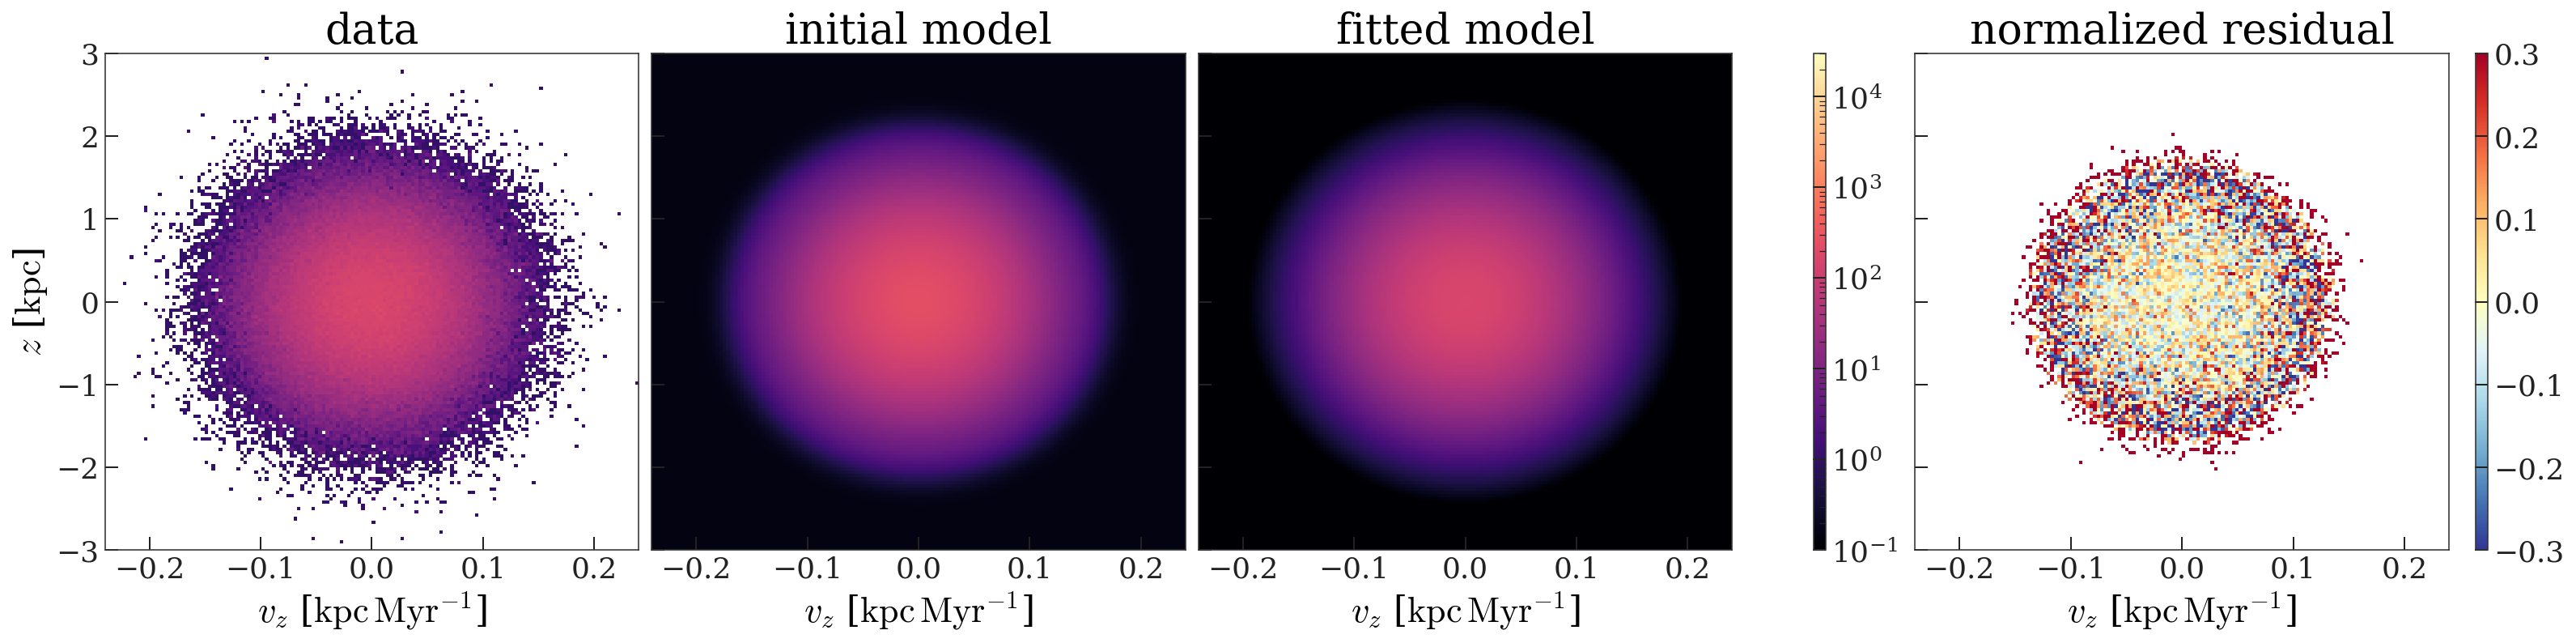

In [360]:
fig, axes = oti.plot.plot_data_models_residual(data, model, params0, res.params)

In [361]:
bu = plt.get_cmap("Blues")
gr = plt.get_cmap("Greens")
tmpx = np.linspace(0.02, 1.0, 64)
color_list = np.concatenate((bu(tmpx)[::-1], gr(tmpx)[1:]))
BuGr = mpl.colors.ListedColormap(color_list, name="BuGr")
BuGr_r = mpl.colors.ListedColormap(color_list[::-1], name="BuGr_r")

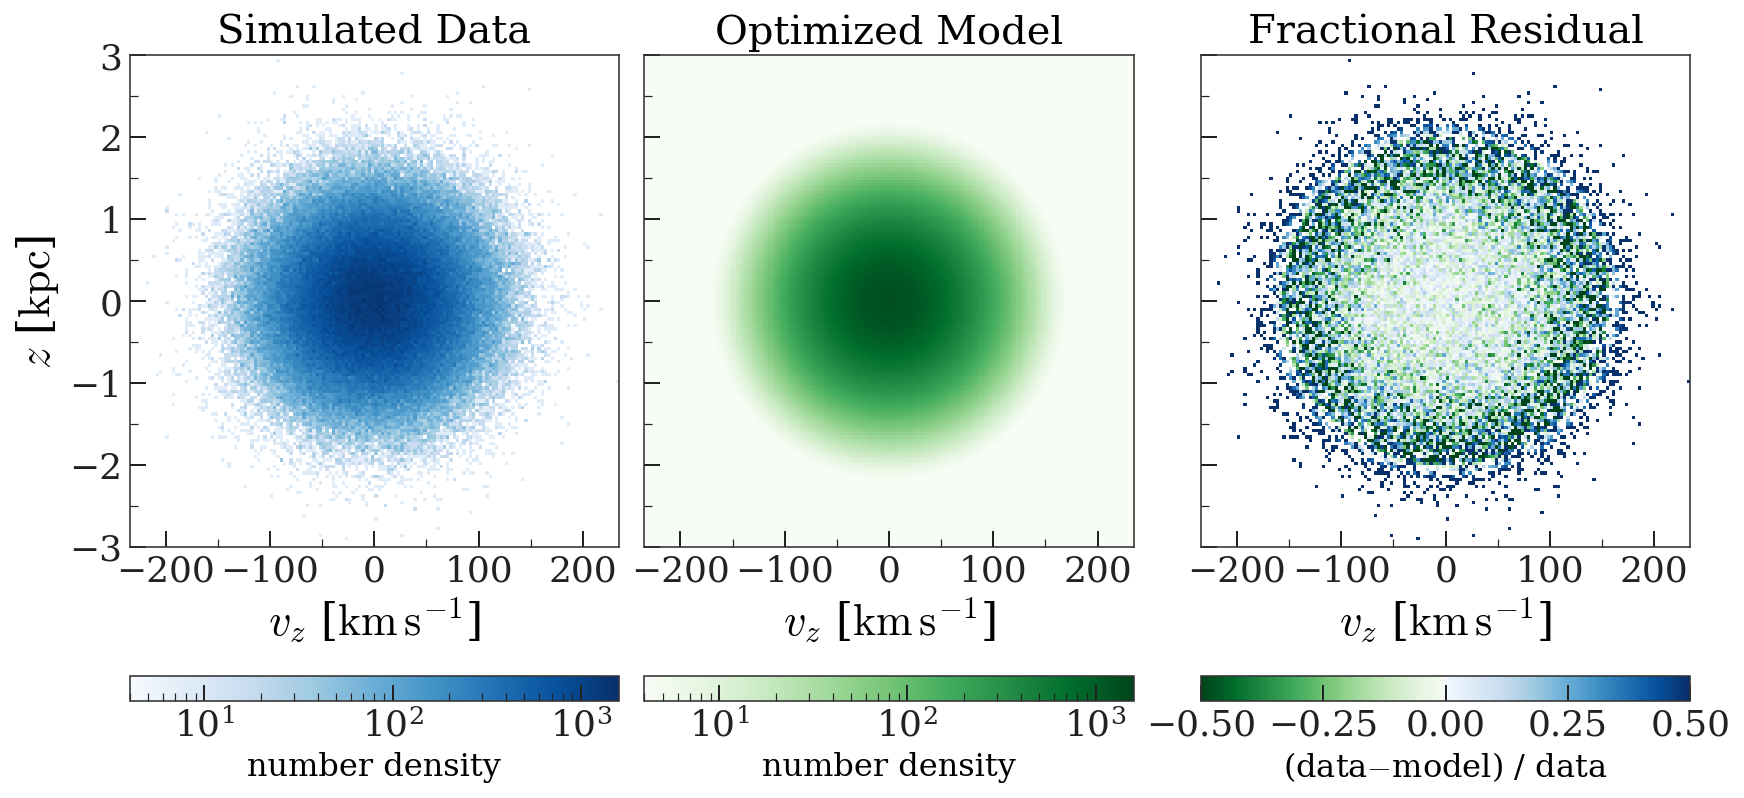

In [362]:
cb_labelsize = 16

data_z = data["z"]
data_vz = (data["vz"] * u.kpc / u.Myr).to_value(u.km / u.s)
factor = np.diff(data["z"][:, 0])[0] * np.diff(data_vz[0])[0]

fig, axes = plt.subplots(
    1, 3, figsize=(12, 5.5), sharex=True, sharey=True, constrained_layout=True
)

norm = mpl.colors.LogNorm(vmin=0.5 / factor, vmax=2e2 / factor)
cs = axes[0].pcolormesh(
    data_vz, data_z, data["H"] / factor, cmap="Blues", norm=norm, rasterized=True
)
cb = fig.colorbar(cs, ax=axes[0], orientation="horizontal")
cb.set_label("number density", fontsize=cb_labelsize)

cs = axes[1].pcolormesh(
    data_vz,
    data_z,
    np.exp(model.ln_density(data["z"], data["vz"], res.params)) / factor,
    norm=norm,
    cmap="Greens",
    rasterized=True,
)
cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
cb.set_label("number density", fontsize=cb_labelsize)

cs = axes[2].pcolormesh(
    data_vz,
    data_z,
    (data["H"] - np.exp(model.ln_density(data["z"], data["vz"], res.params)))
    / data["H"],
    cmap=BuGr_r,
    vmin=-0.5,
    vmax=0.5,
    rasterized=True,
)
cb = fig.colorbar(cs, ax=axes[2], orientation="horizontal")
cb.set_label("(data$-$model) / data", fontsize=cb_labelsize)

# Titles
axes[0].set_title("Simulated Data", fontsize=20)
axes[1].set_title("Optimized Model", fontsize=20)
axes[2].set_title("Fractional Residual", fontsize=20)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")

# Ticks
axes[0].set_xticks(np.arange(-200, 200 + 1, 100))
axes[0].set_xticks(np.arange(-200, 200 + 1, 50), minor=True)
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 1))
axes[1].set_yticks(np.arange(-3, 3 + 1e-3, 0.5), minor=True)

for ax in axes:
    ax.set_aspect(2 * np.pi / Omega.value)

fig.savefig("../tex/figures/sho-data-model.pdf", dpi=250)

In [369]:
errs = model.error_propagate_uncertainty(res.params, data)

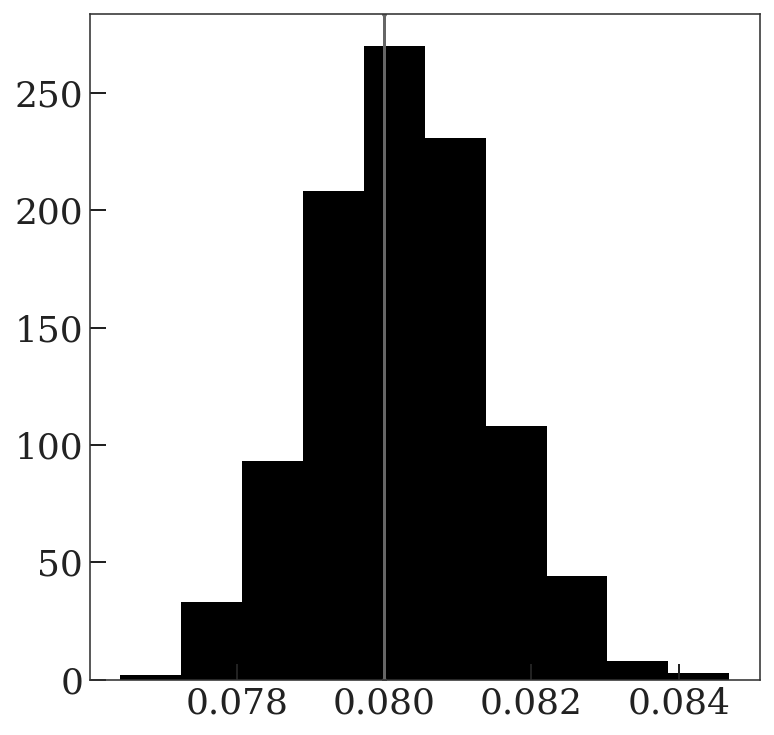

In [370]:
plt.hist(np.exp(np.random.normal(res.params["ln_Omega"], errs["ln_Omega"], size=1000)))
plt.axvline(Omega.value)

In [384]:
# par_samples = model.get_crlb_error_samples(res.params, data, size=128)
par_samples = get_crlb_error_samples(model, res.params, data, size=128)

In [407]:
par_samples.keys()

dict_keys(['e_params', 'ln_Omega', 'ln_dens_params', 'vz0', 'z0'])

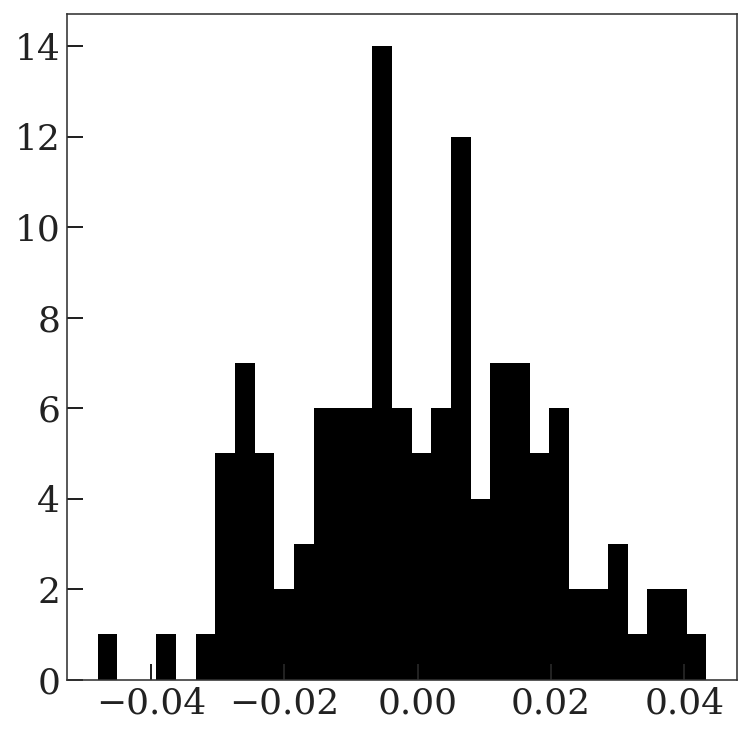

In [409]:
plt.hist(par_samples["e_params"][2]["vals"][:, 1], bins=31);

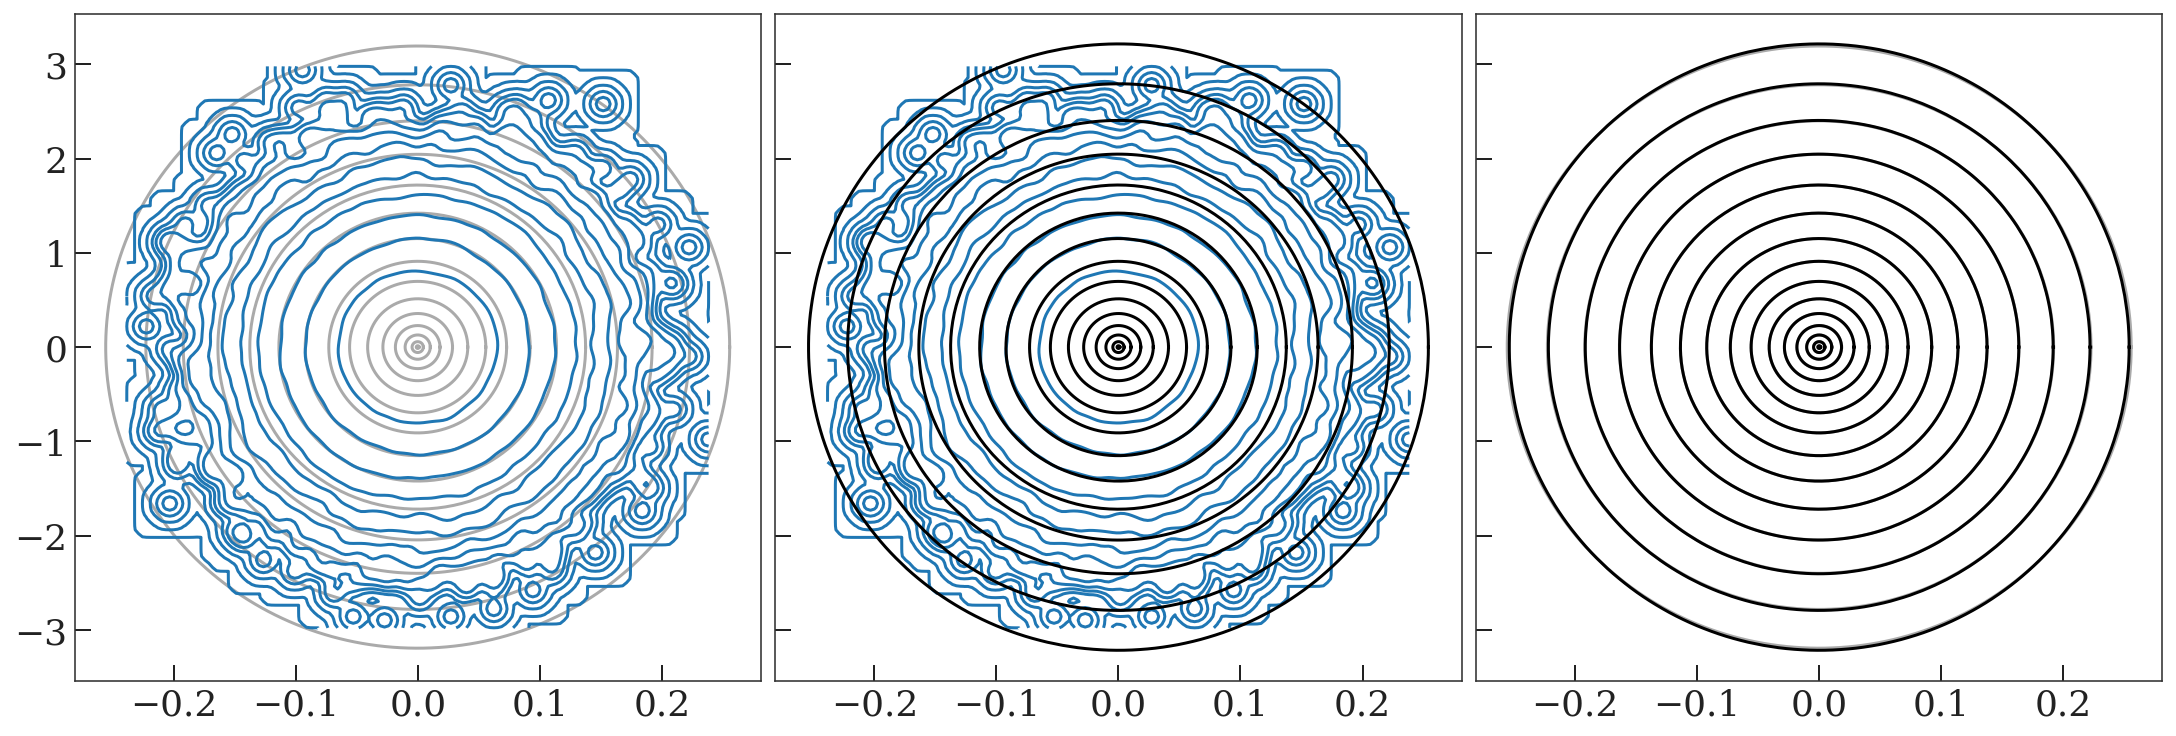

In [277]:
_thz = np.linspace(0, 2 * np.pi, 256)

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True
)

_H = convolve(data["H"], Gaussian2DKernel(2.0))
_levels = np.exp(np.nanpercentile(np.log(_H[_H != 0]), np.linspace(0, 100.0, 16)))
for ax in axes[:2]:
    ax.contour(data["vz"], data["z"], _H, levels=_levels, colors="tab:blue", zorder=-5)

for _rz in np.linspace(1e-3, max_rzp.value**0.5, 16) ** 2:
    tmp = np.array(
        [model.get_rz_prime(_rz, ang, res.params["e_params"]) for ang in _thz]
    )
    for ax in axes[1:]:
        ax.plot(
            tmp * np.sqrt(Omega.value) * np.cos(_thz),
            tmp / np.sqrt(Omega.value) * np.sin(_thz),
            marker="",
            color="k",
        )
    for ax in [axes[0], axes[2]]:
        ax.plot(
            _rz * np.sqrt(Omega.value) * np.cos(_thz),
            _rz / np.sqrt(Omega.value) * np.sin(_thz),
            marker="",
            color="#aaaaaa",
            zorder=-10,
        )

Text(0, 0.5, '$e_m(\\tilde{r}_z)$')

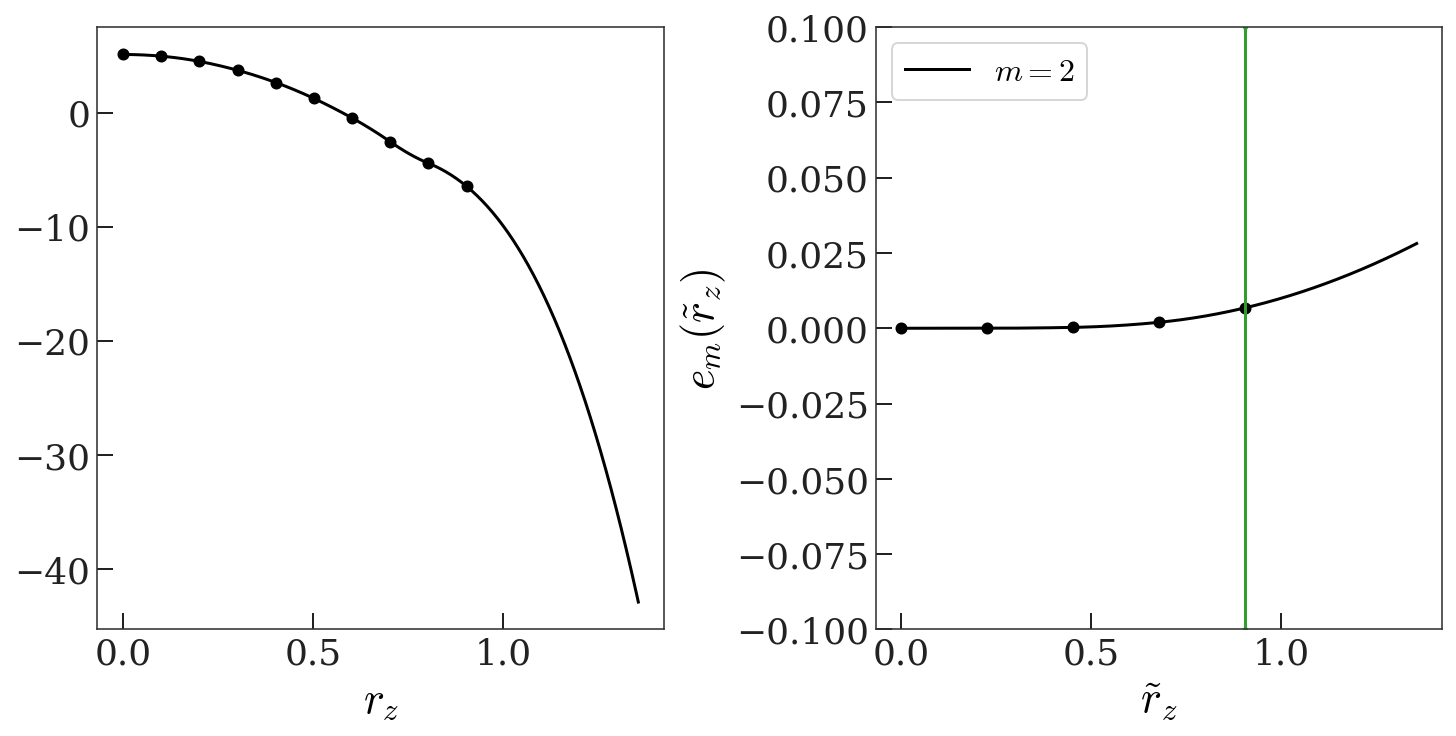

In [278]:
plot_rz = np.linspace(0, 1.5, 301) * max_rzp

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

ax = axes[0]
ax.plot(
    plot_rz,
    model.ln_dens_func(plot_rz, res.params["ln_dens_params"]["ln_dens_vals"]),
    marker="",
)
ax.scatter(
    ln_dens_knots,
    model.ln_dens_func(ln_dens_knots, res.params["ln_dens_params"]["ln_dens_vals"]),
)
# tmp, xe = np.histogram(rzs, bins=np.linspace(0, max_rzpish, 32))
# xc = 0.5 * (xe[:-1] + xe[1:])
# # TODO: how to plot density here
# ax.plot(xc, np.log(tmp * np.diff(xe)))
ax.set_xlabel(r"$r_z$")

ax = axes[1]
es = model.get_es(plot_rz, res.params["e_params"])
for m, ee in es.items():
    ax.plot(plot_rz, ee, marker="", label=f"$m={m}$")
    ax.scatter(
        e_knots[m], model.e_funcs[m](e_knots[m], res.params["e_params"][m]["vals"])
    )
ax.legend(fontsize=16)
ax.set_ylim(-0.1, 0.1)

ax.axvline(max_rzp.value, color="tab:green")
ax.set_xlabel(r"$\tilde{r}_z$")
ax.set_ylabel(r"$e_m(\tilde{r}_z)$")

(-0.0019200000000000003, 0.0019200000000000003)

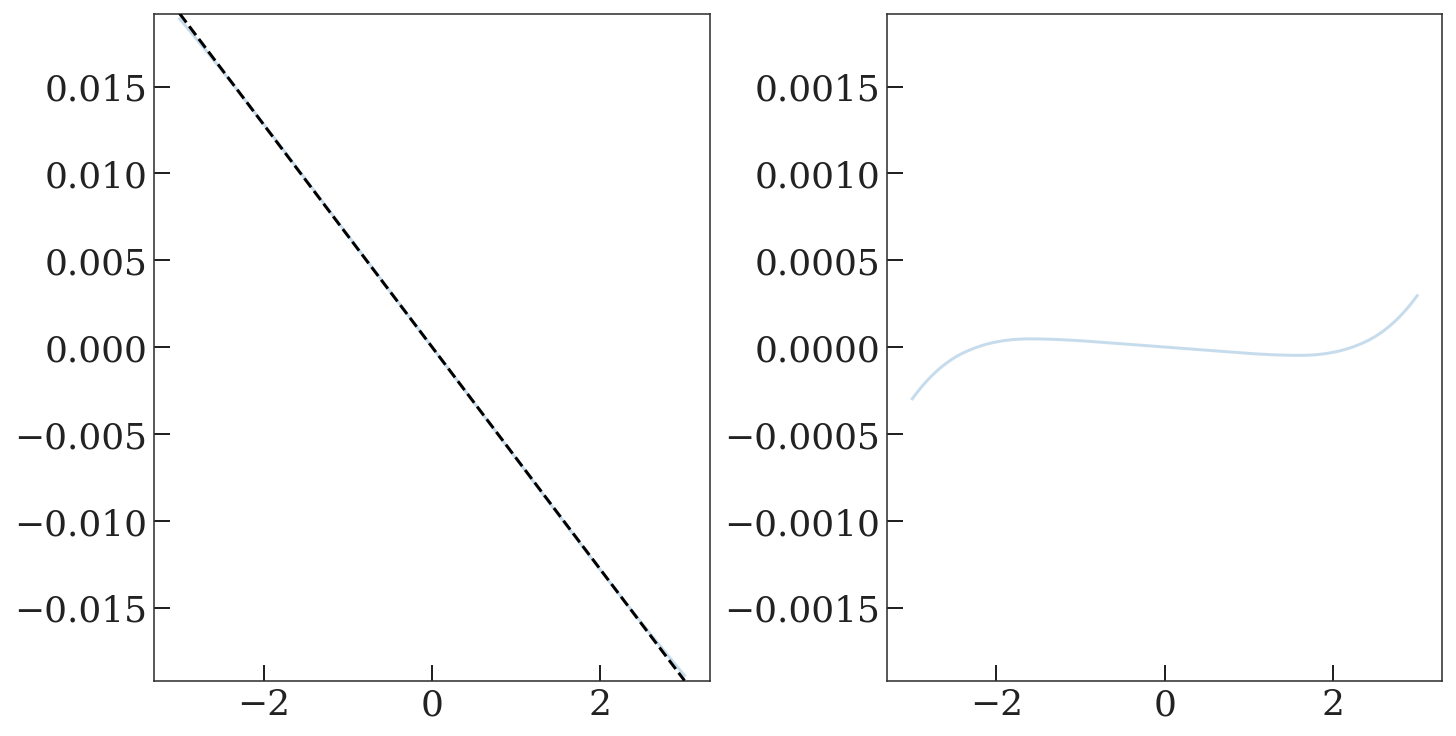

In [280]:
z_grid = np.linspace(-max_z, max_z, 128)

p = res.params

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)

true_az = (-(Omega**2) * z_grid).to(
    galactic["acceleration"], u.dimensionless_angles()
)
axes[0].plot(z_grid, true_az, marker="", zorder=100, color="k", ls="--")

axes[0].plot(
    z_grid, model.get_az(z_grid, p), marker="", alpha=0.25, color="tab:blue", zorder=10
)

axes[1].plot(
    z_grid,
    model.get_az(z_grid, p) - true_az,
    marker="",
    alpha=0.25,
    color="tab:blue",
    zorder=10,
)

axes[0].set_ylim(-(max_z * Omega**2).value, (max_z * Omega.value**2).value)
axes[1].set_ylim(-0.1 * true_az.value.max(), 0.1 * true_az.value.max())

In [281]:
# plt.figure(figsize=(6, 5))
# plt.scatter(
#     pdata['vz'].value,
#     pdata['z'].value,
#     c=Jzs.value,
#     s=2,
# )
# cb = plt.colorbar()
# cb.set_label('$J_z$')

# plt.xlim(zvz_bins['vz'].value.min(), zvz_bins['vz'].value.max())
# plt.ylim(zvz_bins['z'].min(), zvz_bins['z'].max())

In [282]:
aaf = model.compute_action_angle(
    pdata["z"][::10], pdata["vz"][::10], res.params, N_grid=25
)

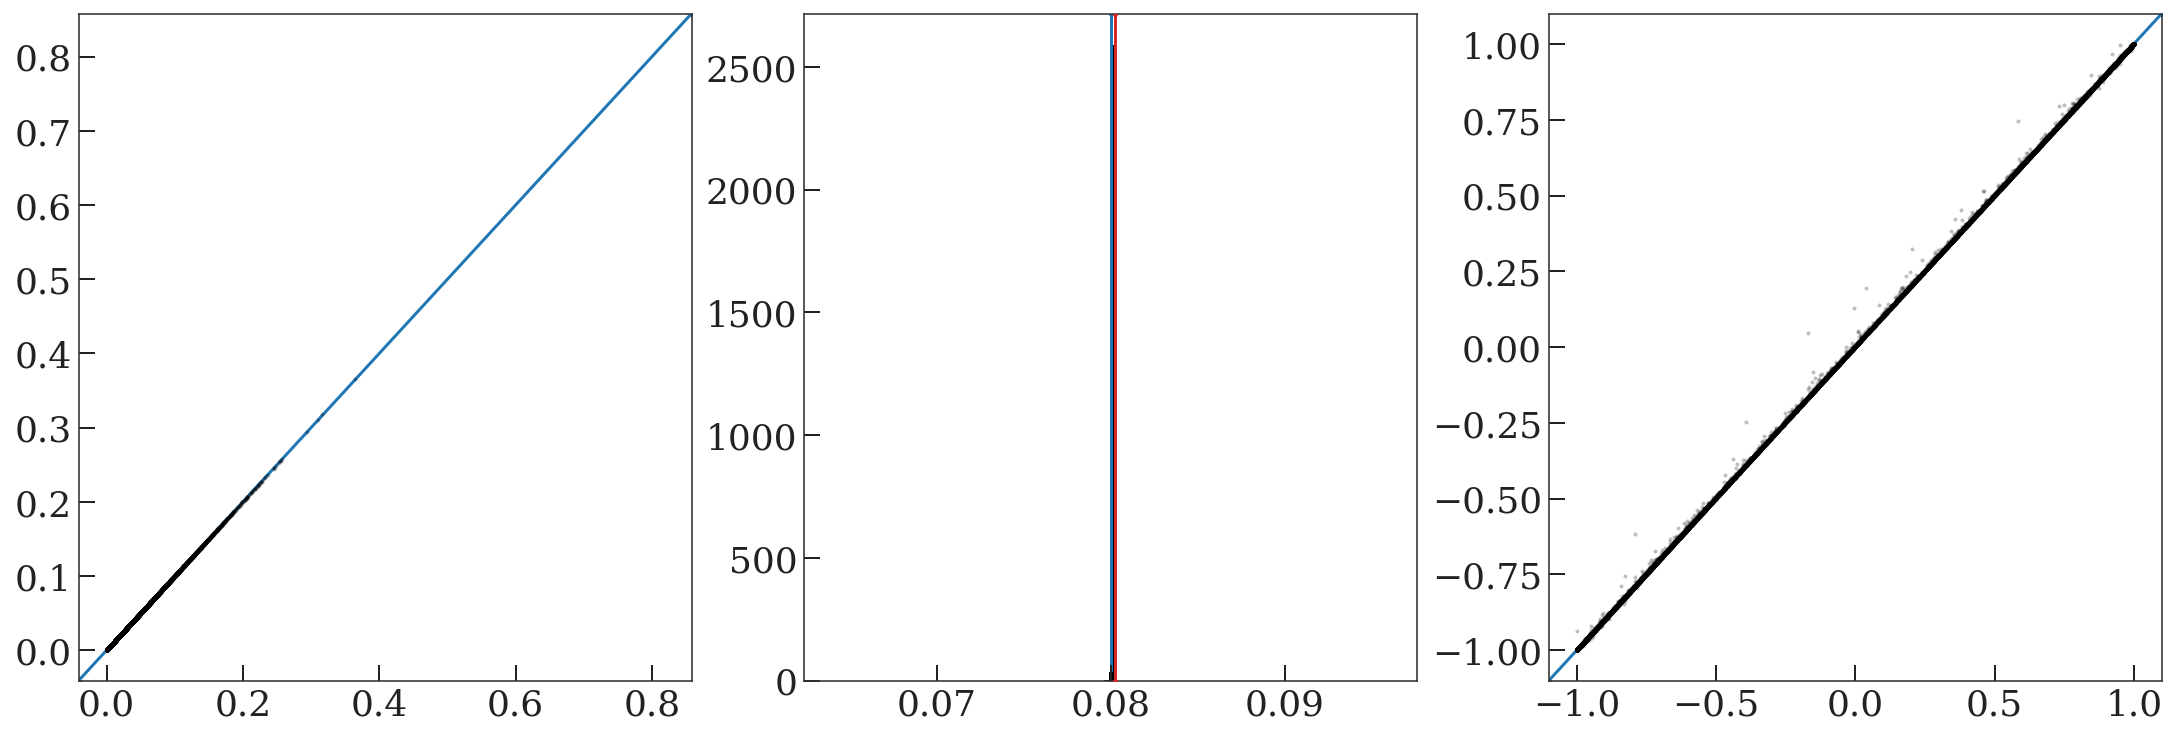

In [283]:
ptstyle = dict(marker="o", mew=0, ms=2.0, ls="none", alpha=0.25)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].plot(Jzs[::10].value, aaf["J_z"].value, **ptstyle)
axes[0].axline(
    [0, 0], [max_rzp.value**2, max_rzp.value**2], color="tab:blue", zorder=-10
)

axes[1].hist(aaf["Omega_z"].value[::10], bins=np.linspace(0.8, 1.2, 128) * Omega.value)
axes[1].axvline(Omega.value, color="tab:blue", zorder=-10)
axes[1].axvline(np.exp(res.params["ln_Omega"]), color="tab:red", zorder=10)

axes[2].plot(np.cos(thzs[::10]), np.cos(aaf["theta_z"]), **ptstyle)
axes[2].axline([0, 0], [1, 1], color="tab:blue", zorder=-10)

---

## Bootstrap

In [284]:
def resample_data(z, vz, bins, K=32, seed=42):
    rng = np.random.default_rng(seed)

    datas = []
    for k in range(K):
        idx = rng.choice(z.size, size=z.size, replace=True)
        data = oti.DensityOrbitModel.get_data_im(z=z[idx], vz=vz[idx], bins=bins)
        datas.append(data)

    return datas

In [285]:
trial_datas = resample_data(pdata["z"], pdata["vz"], bins=zvz_bins, K=128)

In [286]:
opt_pars = []
opt_states = []
for n, trial_data in enumerate(trial_datas):
    tmp = model.optimize(
        params0=params0, bounds=bounds, jaxopt_kwargs={"tol": 1e-8}, **trial_data
    )
    opt_pars.append(tmp.params)
    opt_states.append(tmp.state)

    if not tmp.state.success:
        print(f"trial {n} failed")

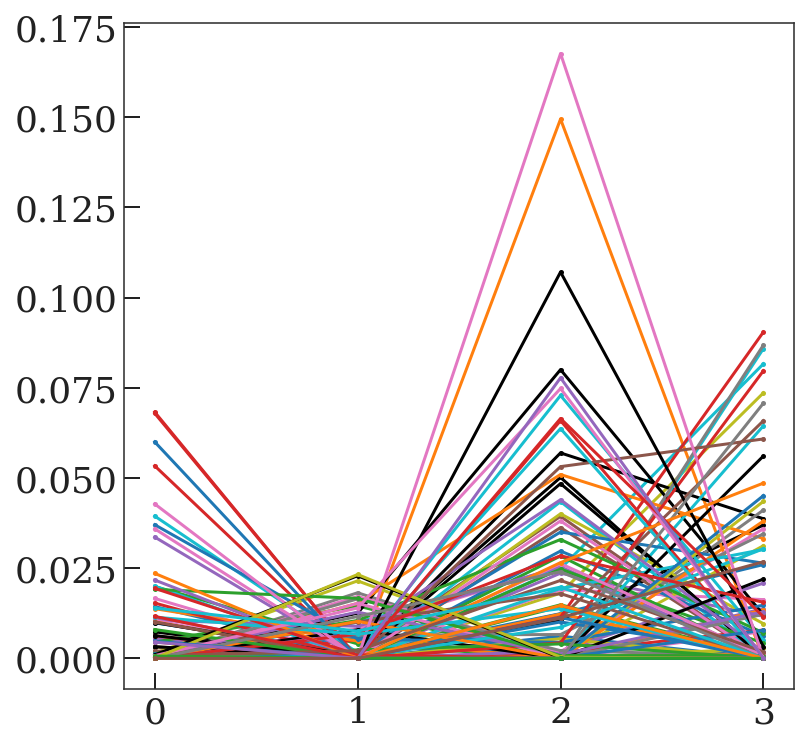

In [287]:
for p in opt_pars:
    plt.plot(p["e_params"][2]["vals"])

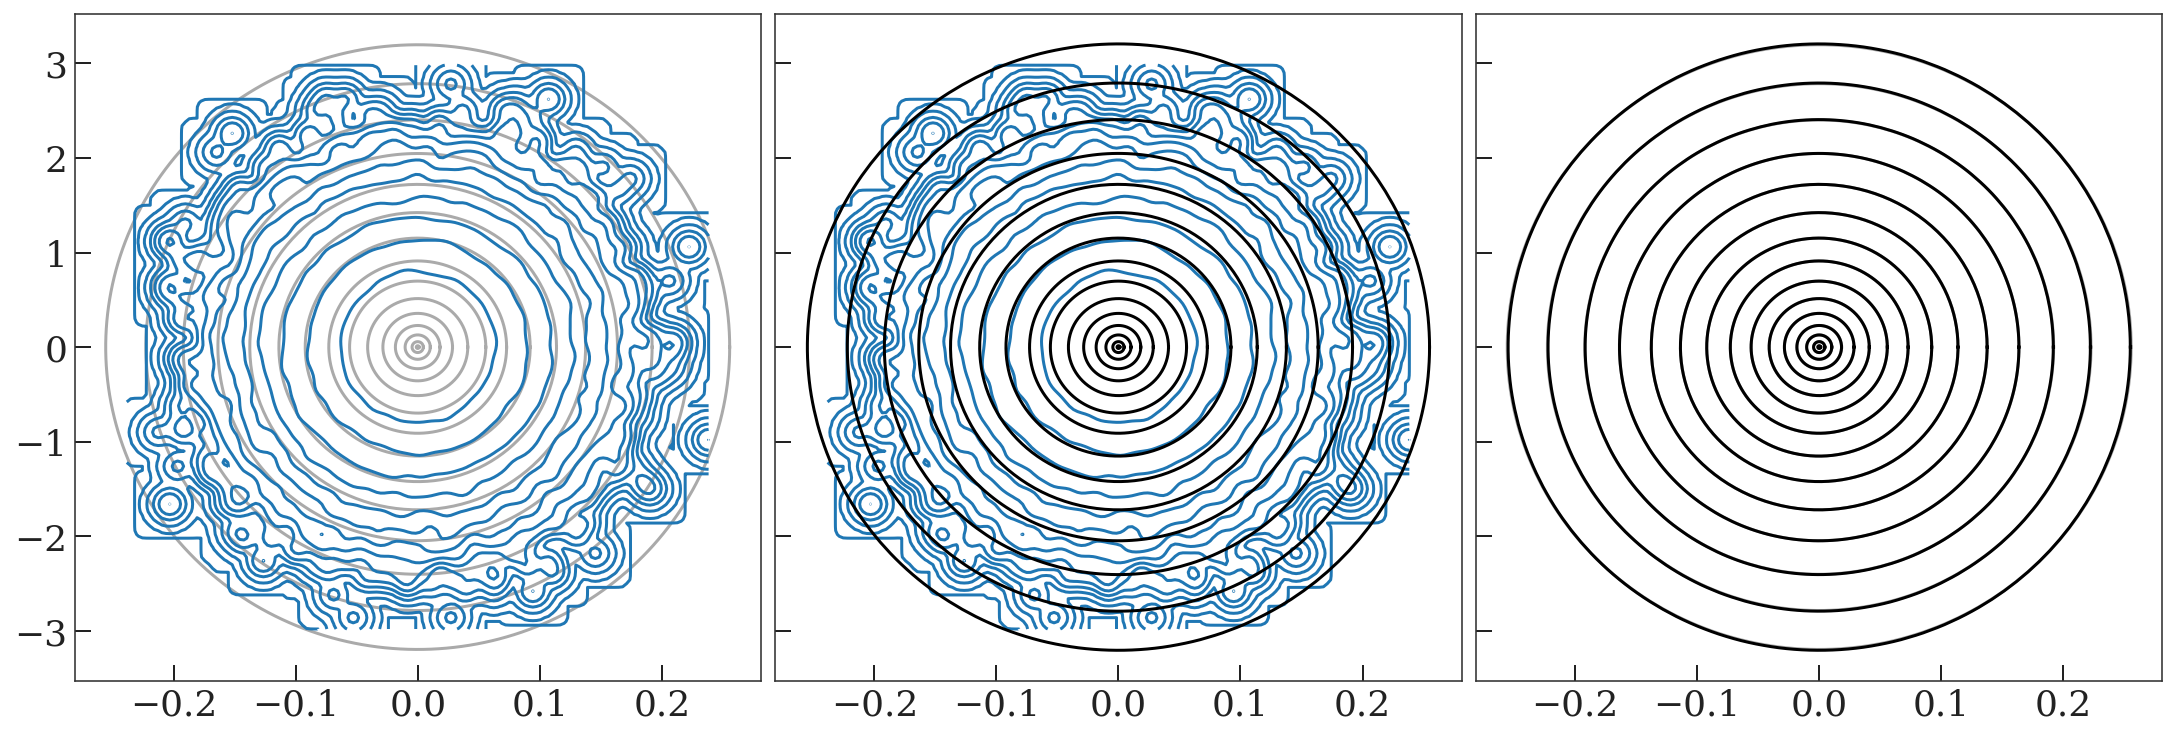

In [288]:
d = trial_datas[1]
p = opt_pars[1]

_thz = np.linspace(0, 2 * np.pi, 256)

fig, axes = plt.subplots(
    1, 3, figsize=(15, 5), constrained_layout=True, sharex=True, sharey=True
)

_H = convolve(d["H"], Gaussian2DKernel(2.0))
_levels = np.exp(np.nanpercentile(np.log(_H[_H != 0]), np.linspace(0, 100.0, 16)))
for ax in axes[:2]:
    ax.contour(d["vz"], d["z"], _H, levels=_levels, colors="tab:blue", zorder=-5)

for _rz in np.linspace(1e-3, max_rzp.value**0.5, 16) ** 2:
    tmp = np.array([model.get_rz_prime(_rz, ang, p["e_params"]) for ang in _thz])
    for ax in axes[1:]:
        ax.plot(
            tmp * np.sqrt(Omega.value) * np.cos(_thz),
            tmp / np.sqrt(Omega.value) * np.sin(_thz),
            marker="",
            color="k",
        )
    for ax in [axes[0], axes[2]]:
        ax.plot(
            _rz * np.sqrt(Omega.value) * np.cos(_thz),
            _rz / np.sqrt(Omega.value) * np.sin(_thz),
            marker="",
            color="#aaaaaa",
            zorder=-10,
        )

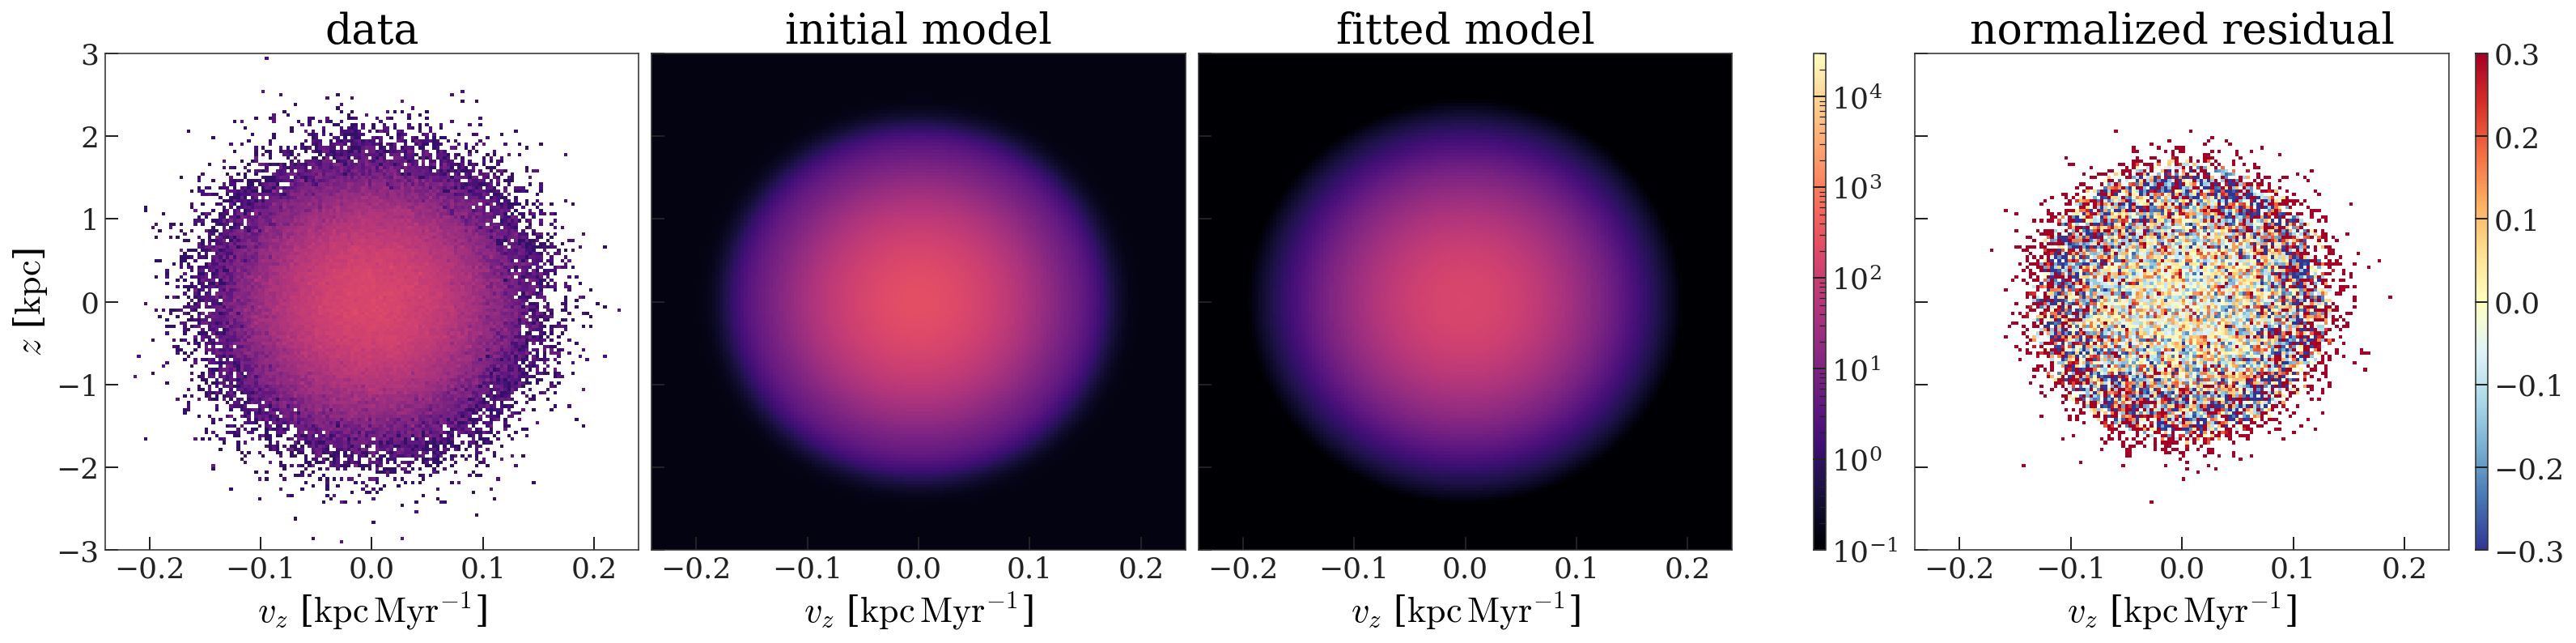

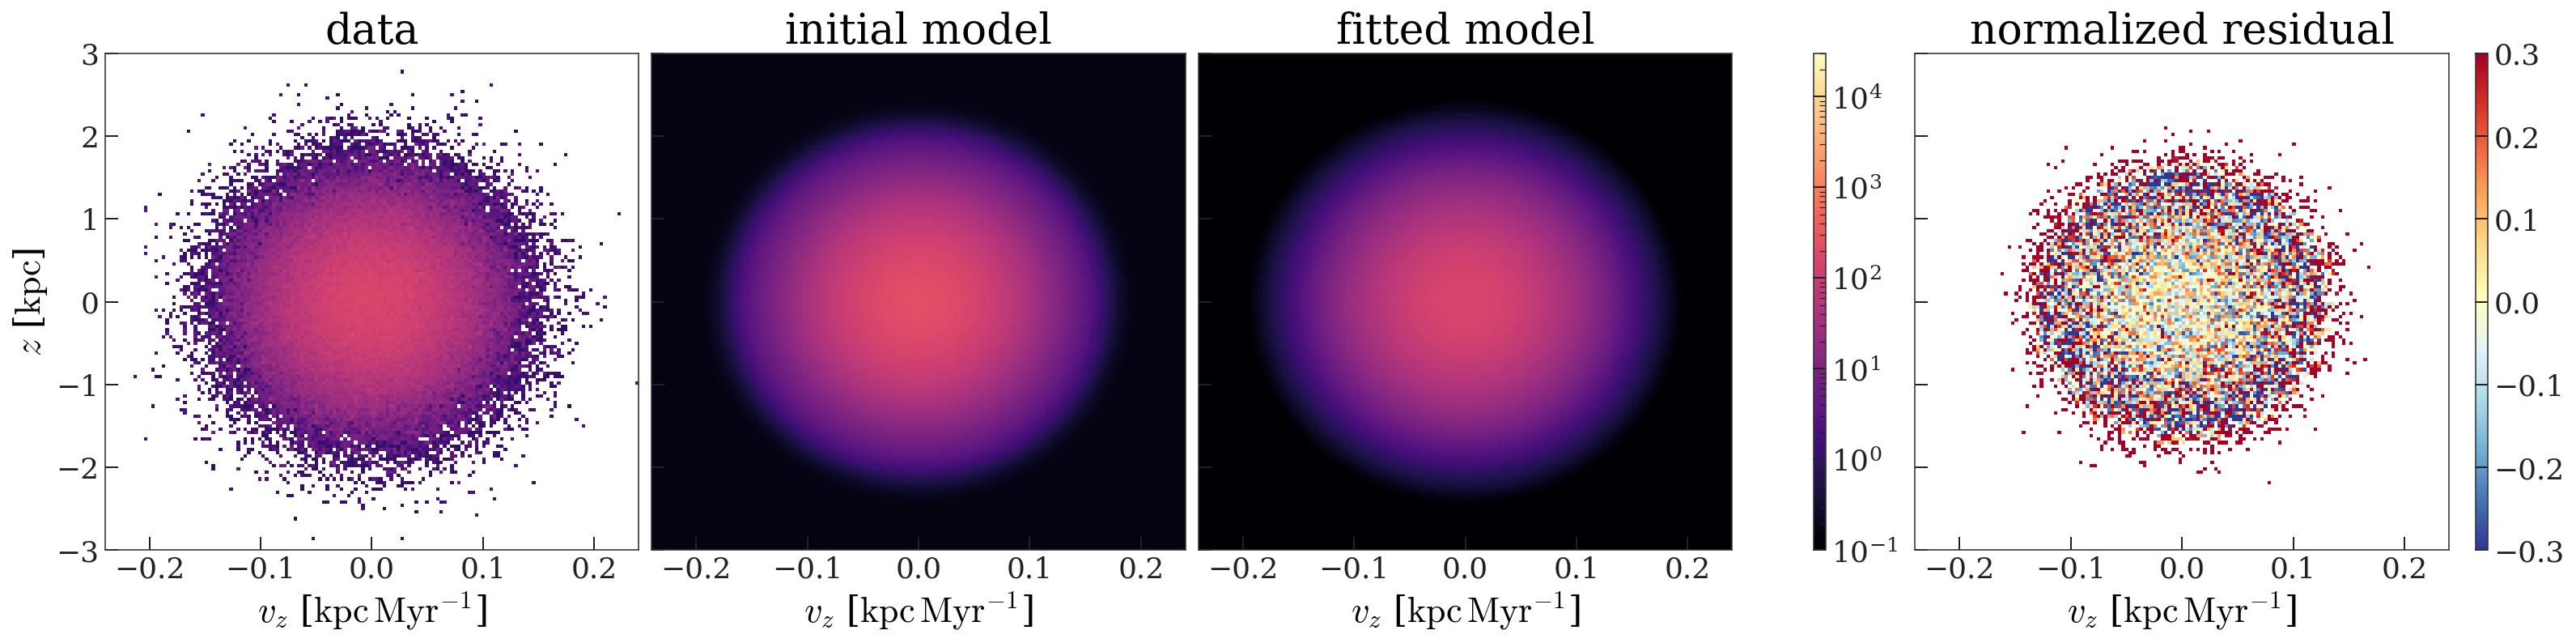

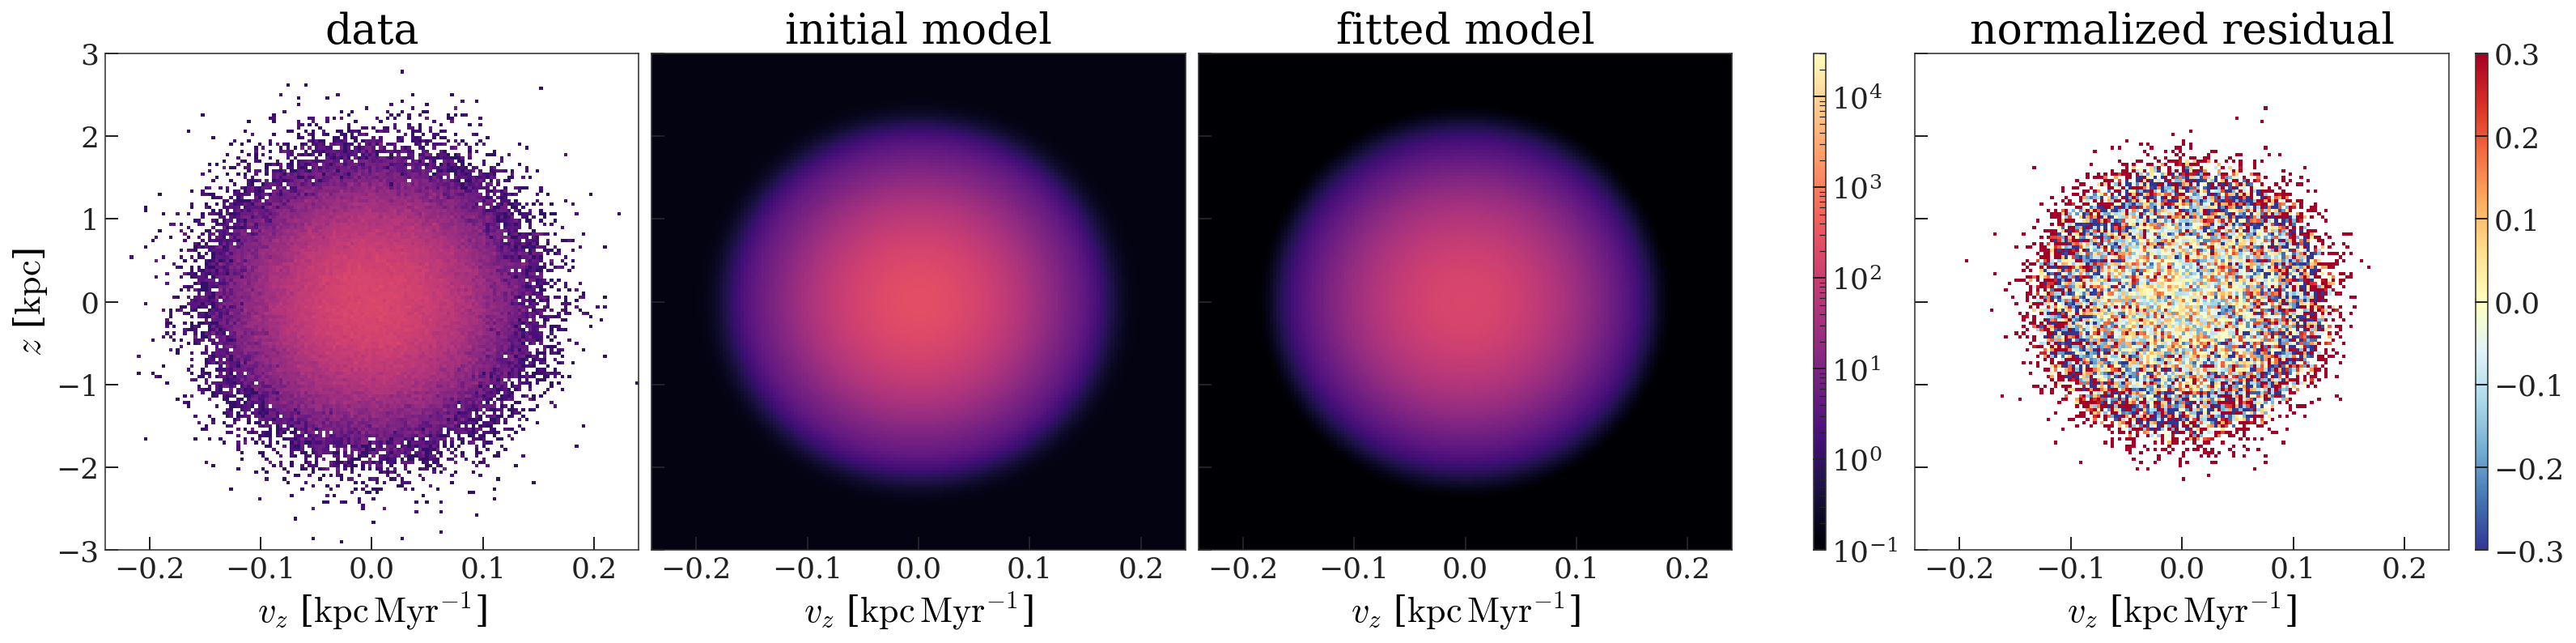

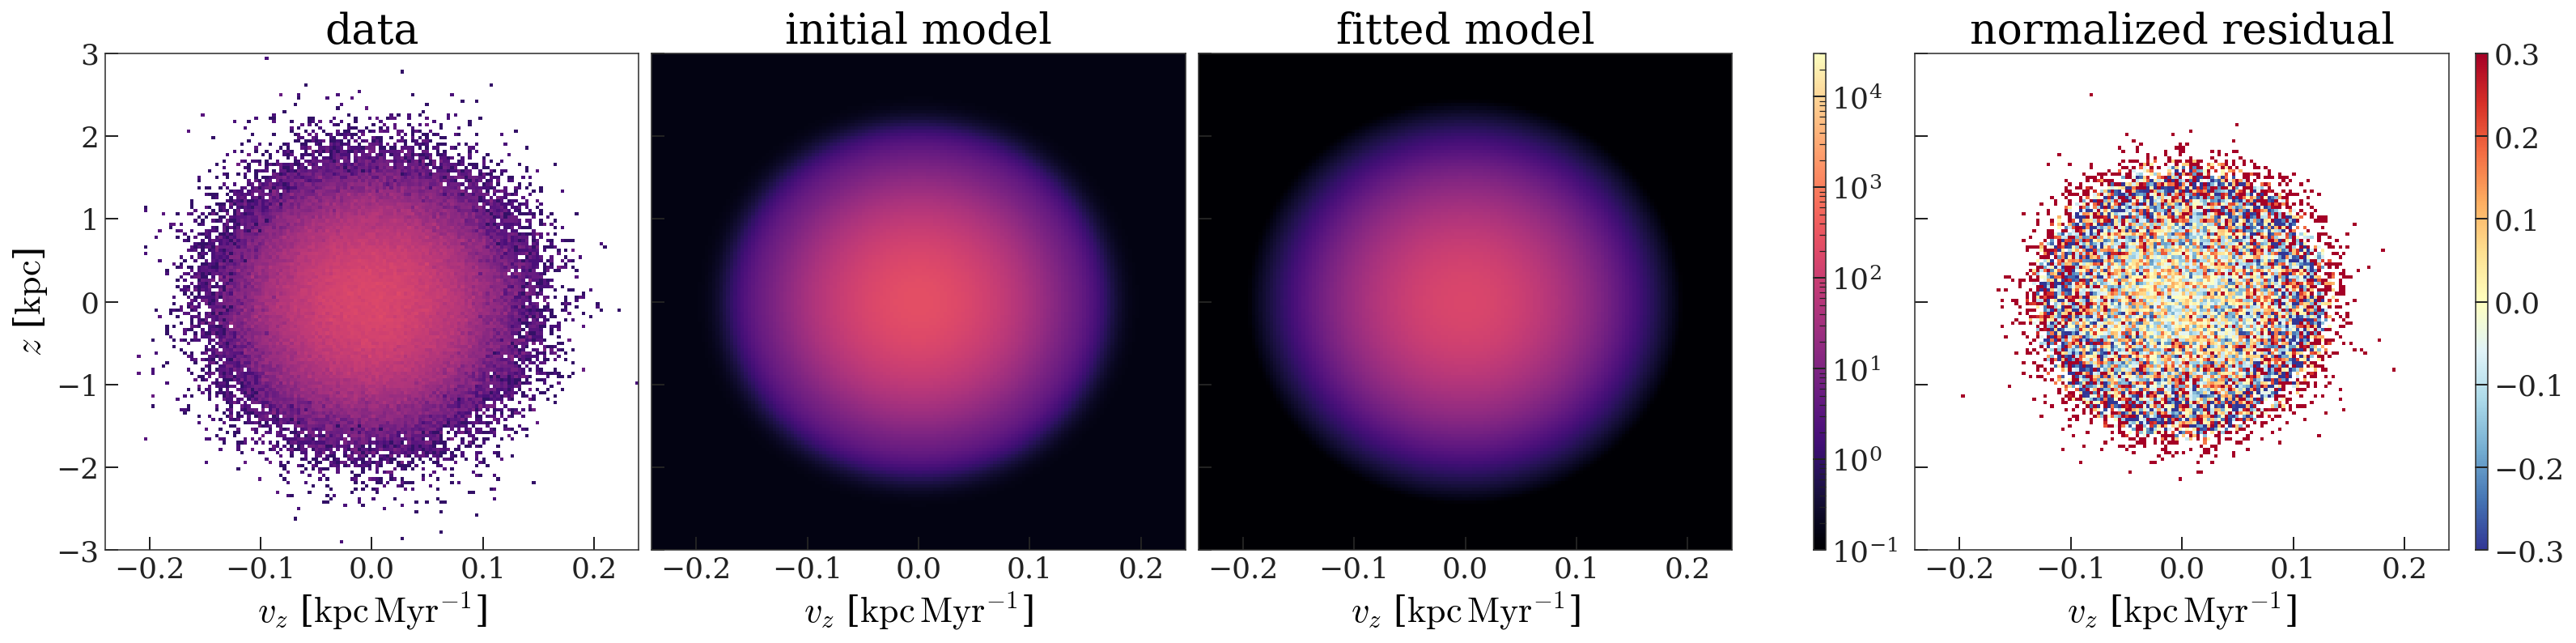

In [289]:
for tdata, p in zip(trial_datas, opt_pars[:4]):
    fig, axes = oti.plot.plot_data_models_residual(tdata, model, params0, p)

Text(0, 0.5, '$e_m(\\tilde{r}_z)$')

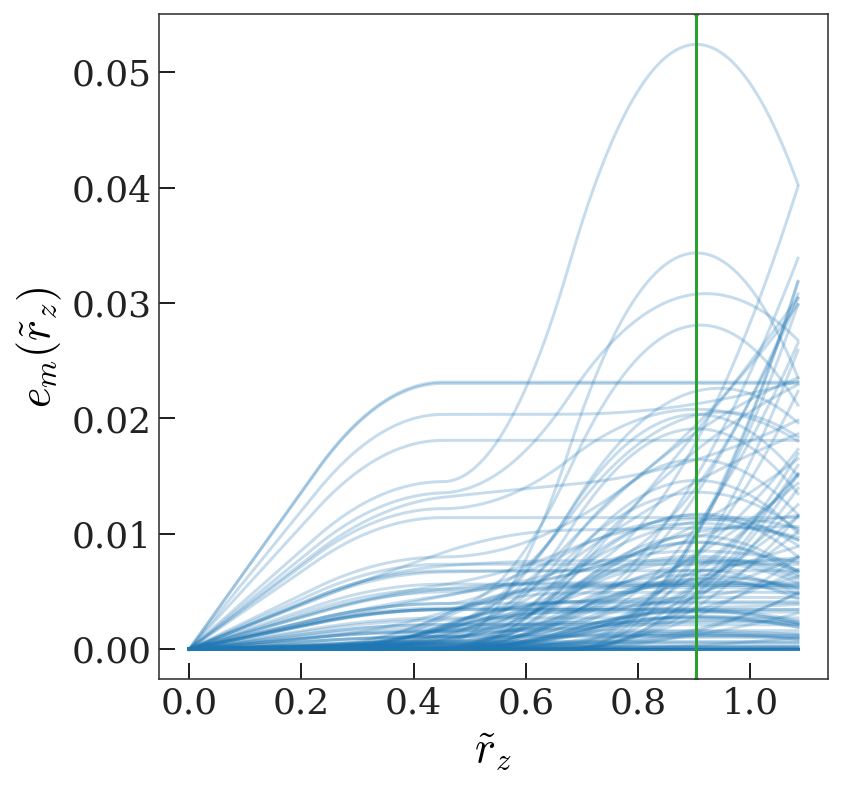

In [290]:
plot_rz = np.linspace(0, 1.2 * max_rzp.value, 301)

_colors = ["tab:blue", "tab:orange", "tab:green"]
for p in opt_pars:
    es = model.get_es(plot_rz, p["e_params"])
    for color, (m, ee) in zip(_colors, es.items()):
        plt.plot(plot_rz, ee, marker="", alpha=0.25, color=color)

plt.axvline(max_rzp.value, color="tab:green")
plt.xlabel(r"$\tilde{r}_z$")
plt.ylabel(r"$e_m(\tilde{r}_z)$")

In [291]:
eval_z = 1.0
true_az = -(Omega**2) * eval_z
azs = np.zeros(len(opt_pars))
for n, p in enumerate(opt_pars):
    azs[n] = model.get_az([eval_z] * u.kpc, p).value

true_az.value, np.mean(azs), np.std(azs), np.mean(azs) - true_az.value

(-0.0064, -0.006444058033718905, 3.133243189930268e-05, -4.405803371890487e-05)

(-0.2, 0.2)

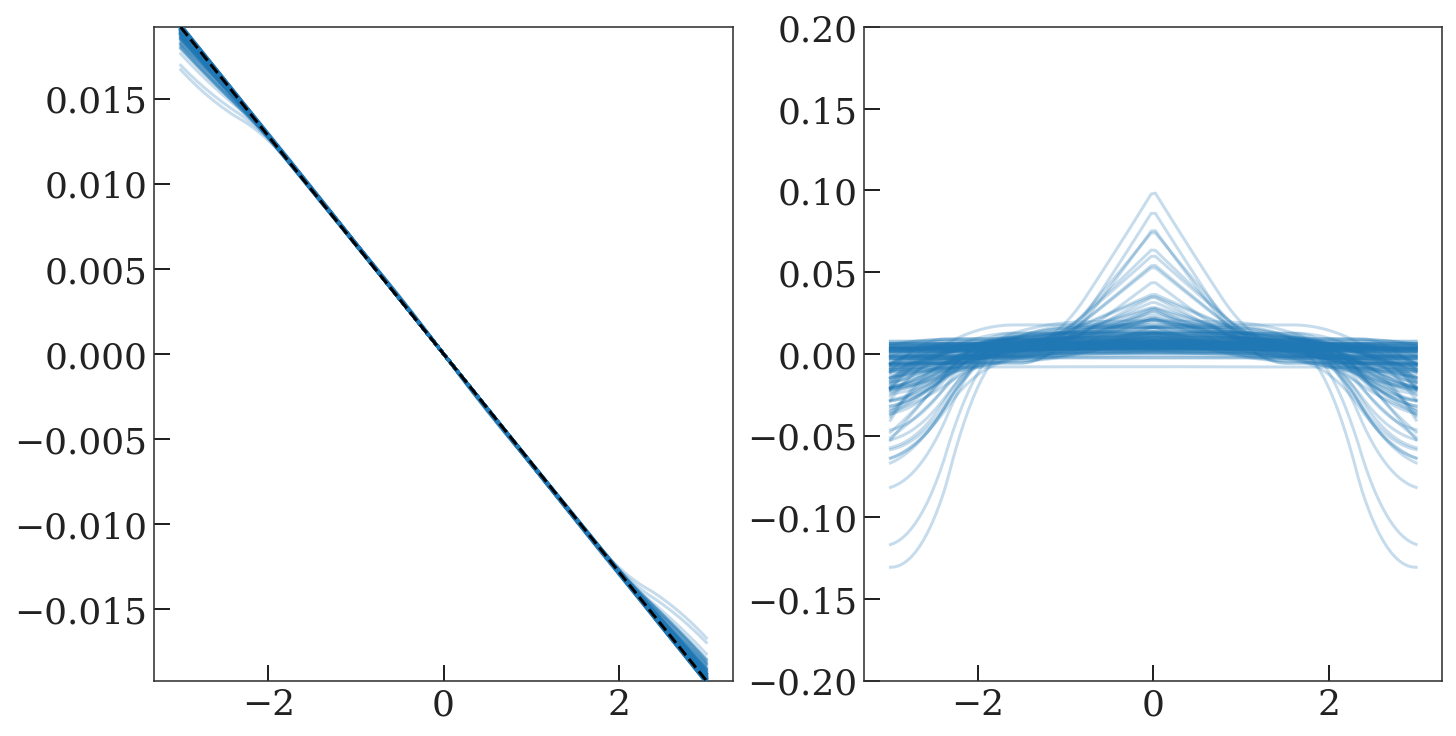

In [292]:
z_grid = np.linspace(-max_z.value, max_z.value, 128)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, constrained_layout=True)

true_az = -(Omega**2) * z_grid
axes[0].plot(z_grid, true_az, marker="", zorder=100, color="k", ls="--")

for p in opt_pars:
    axes[0].plot(
        z_grid,
        model.get_az(z_grid * u.kpc, p),
        marker="",
        alpha=0.25,
        color="tab:blue",
        zorder=10,
    )

    axes[1].plot(
        z_grid,
        (model.get_az(z_grid * u.kpc, p).value - true_az.value) / true_az.value,
        marker="",
        alpha=0.25,
        color="tab:blue",
        zorder=10,
    )

axes[0].set_ylim(-(max_z * Omega**2).value, (max_z * Omega**2).value)
axes[1].set_ylim(-0.2, 0.2)

In [293]:
for p in opt_pars:
    aaf = model.compute_action_angle(pdata["z"], pdata["vz"], p)
    break

ValueError: x and y must have same first dimension, but have shapes (26215,) and (262144,)

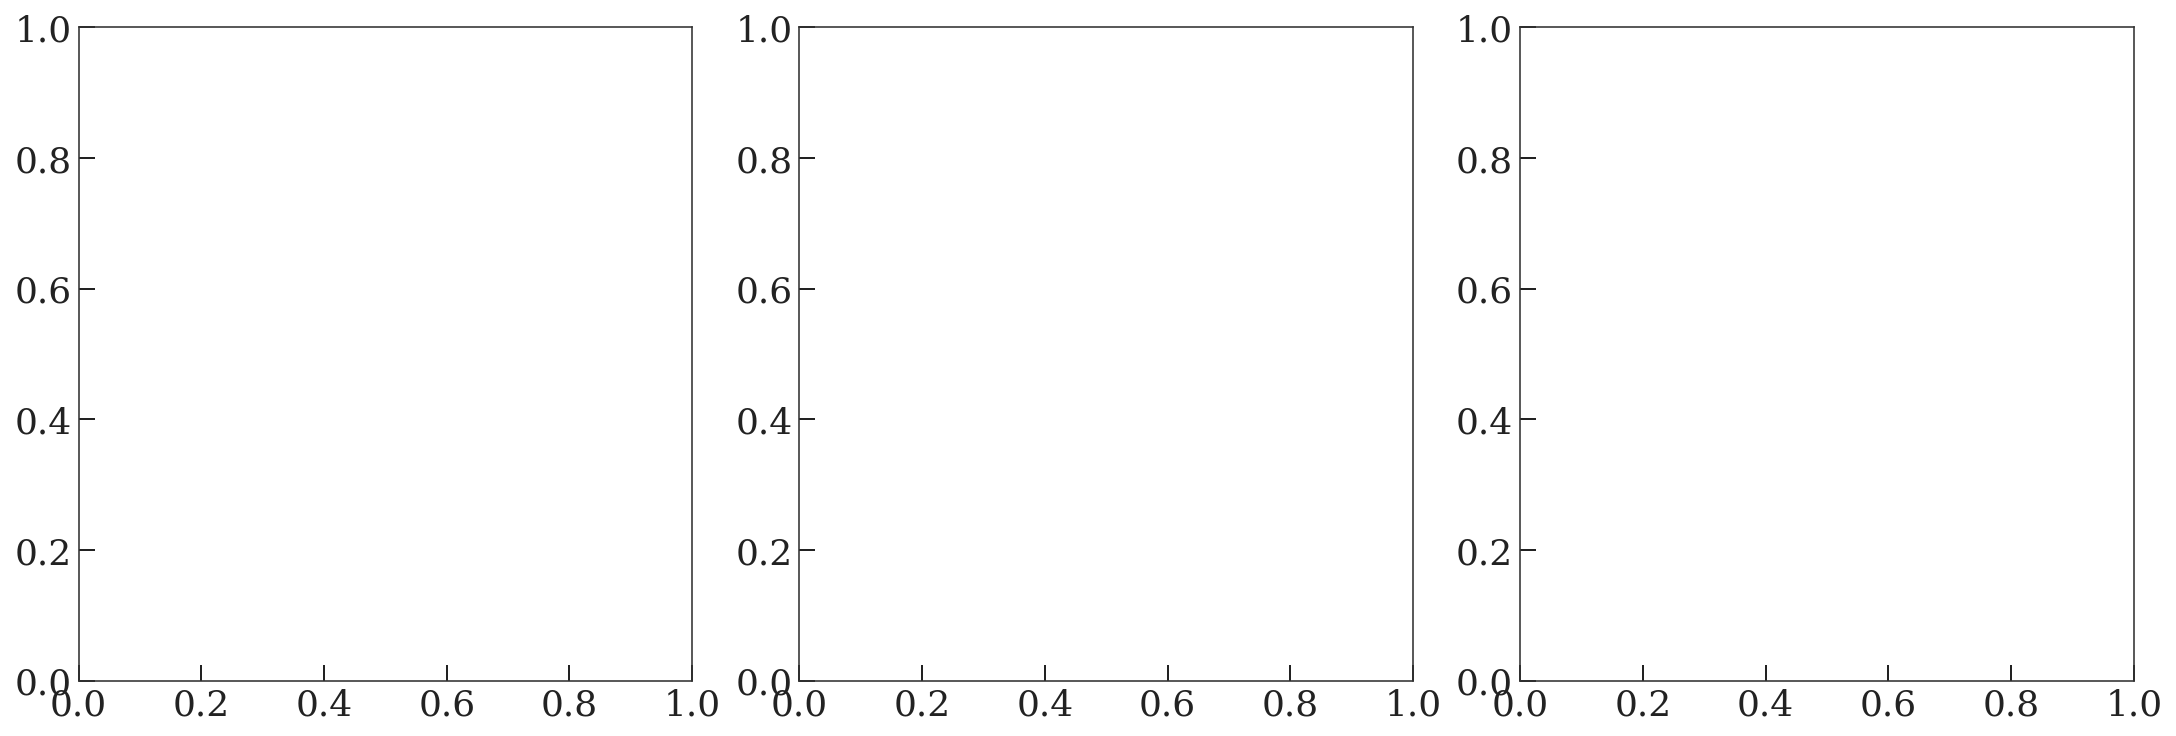

In [116]:
ptstyle = dict(marker="o", mew=0, ms=2.0, ls="none", alpha=0.25)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].plot(Jzs[::10].value, aaf["J_z"].value, **ptstyle)
axes[0].axline(
    [0, 0], [max_rzp.value**2, max_rzp.value**2], color="tab:blue", zorder=-10
)

axes[1].hist(aaf["Omega_z"].value[::10], bins=np.linspace(0.8, 1.2, 128) * Omega.value)
axes[1].axvline(Omega.value, color="tab:blue", zorder=-10)

axes[2].plot(np.cos(thzs[::10]), np.cos(aaf["theta_z"]), **ptstyle)
axes[2].axline([0, 0], [1, 1], color="tab:blue", zorder=-10)